# Import libraries

In [9]:
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import threading
import time

# Data from the Network

In [53]:
n = 9 #number of nodes (posible stations) in the network

candidates = [[1,2,8],[0,2,3],[8,0,1,3,4],[1,2,4,5,7],[2,3,5,6],[3,4,6,7],[4,5],[3,5],[0,2]] #candidates to build an arc

alt_cost = np.array([[0,1.6,0.8,2,1.6,2.5,3,2.5,0.8],[2,0,0.9,1.2,1.5,2.5,2.7,2.4,1.8], 
                [1.5,1.4,0,1.3,0.9,2,1.6,2.3,0.9],[1.9,2,1.9,0,1.8,2,1.9,1.2,2],
                [3,1.5,2,2,0,1.5,1.1,1.8,1.7],[2.1,2.7,2.2,1,1.5,0,0.9,0.9,2.9],
                [2.8,2.3,1.5,1.8,0.9,0.8,0,1.3,2.1],[2.8,2.2,2,1.1,1.5,0.8,1.9,0,0.3],
                [1,1.5,1.1,2.7,1.9,1.8,2.4,3,0]])



 #fixed cost of the arcs
link_cost = np.array([[-1,1.7,2.7,-1,-1,-1,-1,-1,2.9],[1.7,-1,2.1,3,-1,-1,-1,-1,-1],
                    [2.7,2.1,-1,2.6,1.7,-1,-1,-1,2.5],[-1,3,2.6,-1,2.8,2.4,-1,3.2,-1],
                    [-1,-1,1.7,2.8,-1,1.9,3,-1,-1],[-1,-1,-1,2.4,1.9,-1,2.7,2.8,-1],
                    [-1,-1,-1,-1,3,2.7,-1,-1,-1],[-1,-1,-1,3.2,-1,2.8,-1,-1,-1],
                    [2.9,-1,2.5,-1,-1,-1,-1,-1,-1]])
link_cost = 1e6*link_cost/(25*365.25) #daily cost of the infraestucture in 25 years

station_cost = np.array([2,3,2.2,3,2.5,1.3,2.8,2.2,3.1]) #fixed cost of the stations
station_cost = 1e6*station_cost/(25*365.25) #daily cost of the infraestucture in 25 years

link_capacity_slope = 0.08*link_cost
station_capacity_slope = 0.08*station_cost



 #demand between o-d pairs
demand = np.array([[0,9,26,19,13,12,13,8,11]
                   ,[11,0,14,26,7,18,3,6,12]
                   ,[30,19,0,30,24,8,15,12,5],[21,9,11,0,22,16,25,21,23]
                   ,[14,14,8,9,0,20,16,22,21],[26,1,22,24,13,0,16,14,12]
                   ,[8,6,9,23,6,13,0,11,11],[9,2,14,20,18,16,11,0,4]
                   ,[8,7,11,22,27,17,8,12,0]])

demand = 1e3*demand

distance = 10000*np.ones((n,n)) #distances between arcs
for i in range(0,9):
    distance[i,i] = 0
distance[0,1] = 0.75
distance[0,2] = 0.7
distance[0,8] = 0.9

distance[1,2] = 0.6
distance[1,3] = 1.1

distance[2,3] = 1.1
distance[2,4] = 0.5
distance[2,8] = 0.7

distance[3,4] = 0.8
distance[3,5] = 0.7
distance[3,7] = 0.8

distance[4,5] = 0.5
distance[4,6] = 0.7

distance[5,6] = 0.5
distance[5,7] = 0.4
for i in range(0,n):
    for j in range(i+1,n):
        distance[j,i] = distance[i,j] #distances are symmetric

load_factor = 0.25*np.ones(n)

op_link_cost = 4*distance*1e-2 #discutir

congestion_coef_stations = 0.1*np.ones(n)
congestion_coef_links = 0.1*np.ones((n,n))
prices = np.sqrt(distance)
travel_time = 60*distance/30 #time in minutes
alt_time = 60*alt_cost/30 #time in minutes


# Constraints

In [54]:
def make_constraints(stations,stations_prim,links,links_prim,f_cur,f_new,f_ij,delta_links,delta_stations,max_vehicles,load_factor):

    constraints = [] #list of constraints

    for i,j in product(range(n),repeat = 2): 
        if j in candidates[i]:
            c = 0
            for o,d in product(range(n),repeat = 2): 
                c += demand[o,d]*f_ij[n*o+i,n*d+j]
            constraints.append(c <= links[i,j]) #sum_{ij}(f_{ij}^{od}) <= links_{ij} \forall i,j
            constraints.append(c + delta_links[i,j] == links_prim[i,j]) #sum_{ij}(f_{ij}^{od}) + delta_links_{ij} == links_prim{ij} \forall i,j
    for i,j in product(range(n),repeat = 2): 
        constraints.append(links[i,j] == links[j,i]) #links[i,j] = links[j,i]

    for i,j in product(range(n),repeat =2):
        constraints.append(links[i,j] >= 0) #links_{ij} >= 0
        constraints.append(links_prim[i,j] >= 0) #links_prim{ij} >= 0
        constraints.append(delta_links[i,j] >= 0) #delta_links_{ij} >= 0

    for i in range(n):
        constraints.append(links[i,i] == 0) #links_{ii} = 0
        constraints.append(links_prim[i,i] == 0) #links_{ii} = 0
        constraints.append(delta_links[i,i] == 0) #delta_links_{ii} = 0

    for i,j in product(range(n),repeat = 2):
        if j not in candidates[i]:
            constraints.append(links_prim[i,j] == 0) #links_{ij} = 0 \forall j not in candidates[i]

    """
    c = 0
    for i,j in product(range(n),repeat = 2): #budget_constraint
        if j in candidates[i]:
            c += links_prim[i,j]*link_cost[i,j]/2
    for i in range(n):
        c+= stations[i]*station_cost[i]
    constraints.append(c <= budget)
    """
    for i,j in product(range(n),repeat = 2):
        c = 0
        if (j in candidates[i]):
            c += links[j,i]
        constraints.append(load_factor[i]*c <= stations[i]) #load_factor*sum_j(links_ji) <= stations_i 
    for i in range(n):
        constraints.append(stations[i] + delta_stations[i] == stations_prim[i]) #stations_prim = stations + delta_stations

    c = 0
    for i,j in product(range(n),repeat = 2):
        if j in candidates[i]:
            c += links_prim[i,j]
    constraints.append(c <= max_vehicles)
    

    for o,d in product(range(n),repeat = 2):           
        if o != d:
            constraints.append(f_cur[o,d] + f_new[o,d] == 1)
        constraints.append(f_cur[o,d] <= 1)
        constraints.append(f_new[o,d] <= 1)
        constraints.append(f_cur[o,d] >= 0)
        constraints.append(f_new[o,d] >= 0)

    for o,d,i,j in product(range(n),repeat = 4):
        constraints.append(f_ij[n*o+i,n*d+j] <= 1)
        constraints.append(f_ij[n*o+i,n*d+j] >= 0)


    for i in range(n):
        constraints.append(stations[i] >= 0)

    for o,d in product(range(n),repeat = 2):
        if o == d:
            constraints.append(f_cur[o,d] == 0)
            constraints.append(f_new[o,d] == 0)
        if o != d:
            for i in range(n):
                constraints.append(f_ij[n*o+i,n*d+i] == 0) #no flow between same nodes
                for j in range(n):
                    if j not in candidates[i]:
                            constraints.append(f_ij[n*o+i,n*d+j] == 0) #no flow through imposible arcs
                if o == i:
                    c = 0
                    for j in range(n):
                        if j in candidates[i]:
                            c += f_ij[n*o+i,n*d+j]
                            c = c - f_ij[n*o+j,n*d+i]
                    constraints.append(c == 1 - f_cur[o,d]) #origin flow conservation
                if d == i:
                    c = 0
                    for j in range(n):
                        if j in candidates[i]:
                            c += f_ij[n*o+i,n*d+j]
                            c = c - f_ij[n*o+j,n*d+i]
                    constraints.append(c == -1 + f_cur[o,d]) #destination flow conservation
                if (d!=i) and (o!=i):
                    c = 0
                    for j in range(n):
                        if j in candidates[i]:
                            c += f_ij[n*o+i,n*d+j]
                            c = c - f_ij[n*o+j,n*d+i]
                    constraints.append(c == 0)  #intermediate arc flow conservation
    return constraints

# Adjustable Parameters

In [56]:
eps = 1e-2 #small number to avoid infty when dividing
itermax = 8 #max number of iterations
betas = [0,0.001,0.005,0.01,0.05,0.1,0.5,1,5]
max_vehicles = 1e12

# Problem Formulation

In [57]:
import threading
def prob_solve(demand,alt_time,travel_time,prices,op_link_cost,beta,link_capacity_slope,link_cost,station_capacity_slope,station_cost,congestion_coef_links,congestion_coef_stations,max_vehicles):
    links_prev = np.zeros((n,n)) #coefficients for sparsity penalty terms
    stations_prev = np.zeros(n)

    for iter in range(itermax):
        stations = cvx.Variable(n)
        stations_prim = cvx.Variable(n)
        delta_stations = cvx.Variable(n)
        links = cvx.Variable((n,n))
        links_prim = cvx.Variable((n,n))
        delta_links = cvx.Variable((n,n))
        f_cur = cvx.Variable((n,n))
        f_new = cvx.Variable((n,n))
        f_ij = cvx.Variable((n**2,n**2))

        cost = 0

        for i in range(n):
            if iter < (itermax -1):
                cost += (beta)*stations[i]*stations_prev[i]*station_cost[i]
                cost += 0.01*cvx.inv_pos(delta_stations[i]+eps) * congestion_coef_stations[i]
            cost += beta*station_capacity_slope[i]*stations_prim[i]

        for i,j in product(range(n),repeat = 2):
            if j in candidates[i]:
                if iter < (itermax -1):
                    cost += beta*links[i,j]*links_prev[i,j]*link_cost[i,j]/2
                    cost += 0.01*cvx.inv_pos(delta_links[i,j]+eps) * congestion_coef_links[i,j]
                cost += beta*(link_capacity_slope[i,j]/2)*links_prim[i,j]
                cost += op_link_cost[i,j]*links_prim[i,j]
        for o,d,i,j in product(range(n),repeat = 4):
            if (j in candidates[i]) and (o != d):
                cost += f_ij[n*o+i,n*d+j]*demand[o,d]*(travel_time[i,j]+prices[i,j])
        for o,d in product(range(n),repeat = 2):
            if o != d:
                cost += f_cur[o,d]*alt_time[o,d]*demand[o,d] - cvx.entr(f_cur[o,d]*demand[o,d]) - f_cur[o,d]*demand[o,d] - cvx.entr(f_new[o,d]*demand[o,d]) - f_new[o,d]*demand[o,d]

        constraints = make_constraints(stations,stations_prim,links,links_prim,f_cur,f_new,f_ij,delta_links,delta_stations,max_vehicles,load_factor)

        if iter == (itermax -1):
            for i in range(n):
                if (1/stations_prev[i]) < 1:
                    constraints.append(stations[i] == 0)
                    constraints.append(delta_stations[i] == 0)
                    constraints.append(stations_prim[i] == 0)
                else:
                    cost += 0.01*cvx.inv_pos(delta_stations[i]+eps) * congestion_coef_stations[i]
            for i,j in product(range(n),repeat = 2):
                if (j in candidates[i]):
                    if (1/links_prev[i,j] < 1):
                        constraints.append(links[i,j] == 0)
                        constraints.append(links_prim[i,j] == 0)
                        constraints.append(delta_links[i,j] == 0)
                    else:
                        cost += 0.01*cvx.inv_pos(delta_links[i,j]+eps) * congestion_coef_links[i,j]

        prob = cvx.Problem(cvx.Minimize(1e-6*cost),constraints)
        print(f"{threading.current_thread().name}:  running iteration {iter+1}/{itermax}")
        assert prob.is_dcp
        prob.solve(solver='MOSEK',verbose=False)

        if iter < (itermax - 1):
            for i in range(n):
                stations_prev[i] = 1/(stations[i].value + eps)
            for i,j in product(range(n),repeat = 2):
                if j in candidates[i]:
                    links_prev[i,j] = 500/(500*links[i,j].value+eps)

    budget = 0
    stations_sol = stations.value
    links_sol = links.value
    for i in range(n):
        if stations_sol[i] > 1e-1:
            budget += station_cost[i] + station_capacity_slope[i]*stations_prim[i].value
    for i,j in product(range(n),repeat=2):
        if j in candidates[i] and (links_sol[i,j] > 1e-1):
            budget += link_cost[i,j]/2 + (link_capacity_slope[i,j]/2)*links_prim[i,j].value
    np.savez(f"./results/betas/sol_beta={beta}",stations=stations.value,stations_prim=stations_prim.value,delta_stations=delta_stations.value,
             links=links.value,links_prim=links_prim.value,delta_links=delta_links.value,
             f_cur=f_cur.value,f_new=f_new.value,f_ij=f_ij.value)
    
    np.savez(f"./logs/betas/report_beta={beta}",obj=prob.value,budget=budget)



# Run some instances changing beta

In [58]:
# creamos los hilos
ths = []
n_threads = 0
for beta in betas:
    ths.append(threading.Thread(target=prob_solve,args=(demand,alt_time,travel_time,prices,op_link_cost,beta,link_capacity_slope,link_cost,station_capacity_slope,station_cost,congestion_coef_links,congestion_coef_stations,max_vehicles)))
    n_threads += 1

for i in range(n_threads):
    print(f"lanzo hilo {i+1}/{n_threads}")
    ths[i].start()

for i in range(n_threads):
    ths[i].join()



lanzo hilo 1/9
lanzo hilo 2/9
lanzo hilo 3/9
lanzo hilo 4/9
lanzo hilo 5/9
lanzo hilo 6/9
lanzo hilo 7/9
lanzo hilo 8/9
lanzo hilo 9/9


/Users/fernandorealrojas/tfgenv/lib/python3.8/site-packages/cvxpy/problems/problem.py:157: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


Thread-122:  running iteration 1/8
Thread-120:  running iteration 1/8
Thread-118:  running iteration 1/8
Thread-125:  running iteration 1/8
Thread-121:  running iteration 1/8
Thread-123:  running iteration 1/8
Thread-126:  running iteration 1/8
Thread-119:  running iteration 1/8
Thread-124:  running iteration 1/8
Thread-119:  running iteration 2/8
Thread-124:  running iteration 2/8Thread-122:  running iteration 2/8

Thread-123:  running iteration 2/8
Thread-125:  running iteration 2/8
Thread-120:  running iteration 2/8
Thread-126:  running iteration 2/8
Thread-121:  running iteration 2/8
Thread-118:  running iteration 2/8
Thread-122:  running iteration 3/8
Thread-119:  running iteration 3/8
Thread-124:  running iteration 3/8
Thread-126:  running iteration 3/8
Thread-125:  running iteration 3/8
Thread-121:  running iteration 3/8
Thread-120:  running iteration 3/8
Thread-123:  running iteration 3/8
Thread-118:  running iteration 3/8
Thread-126:  running iteration 4/8
Thread-122:  running

[[-0.          0.32419408  0.64370575  0.81309435  0.67798293  0.66347157
   0.56217365  0.8765205   0.750463  ]
 [ 0.18420785 -0.          0.54573484  0.69202566  0.66605586  0.60387779
   0.64236641  0.72327588  0.65135114]
 [ 0.33680527  0.32461868 -0.          0.64899534  0.4950954   0.38061083
   0.67829882  0.57169381  0.61125529]
 [ 0.84221014  0.34382529  0.38356613 -0.          0.26658263  0.15990767
   0.54804239  0.52686154  0.81434129]
 [ 0.13001024  0.66373206  0.11294416  0.20862429 -0.          0.22949987
   0.51481583  0.4112772   0.63190932]
 [ 0.80936937  0.52648531  0.29282128  0.56092553  0.23392284 -0.
   0.48251678  0.41768819  0.4829683 ]
 [ 0.65110503  0.78385696  0.71730988  0.58812364  0.61171645  0.52964576
  -0.          0.63223224  0.87015859]
 [ 0.80731376  0.78666925  0.6993228   0.57311083  0.54019084  0.46436318
   0.36030104 -0.          0.98264375]
 [ 0.67720657  0.76588407  0.5153366   0.53593867  0.54545558  0.88201789
   0.7955836   0.74790334 -0. 

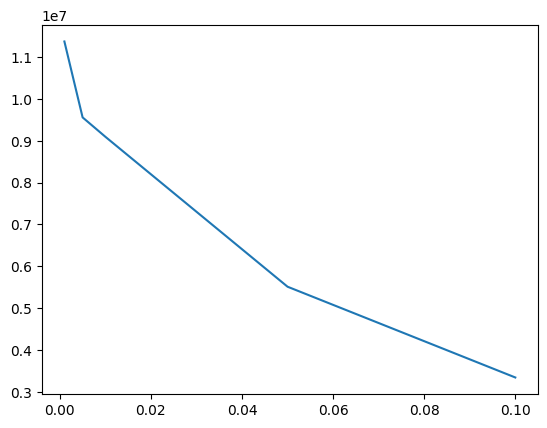

In [61]:
betas = [0,0.001,0.005,0.01,0.05,0.1]
budgets = []
for beta in betas:
    datos = np.load(f"./logs/betas/report_beta={beta}.npz")
    sol = np.load(f"./results/betas/sol_beta={beta}.npz")
    print(sol['f_cur'])
    print(f"beta = {beta}, budget = {datos['budget']}")
    budgets.append(datos['budget'])


plt.plot(betas[1:],budgets[1:])

In [16]:
import matlab.engine

def sq(num,eng):
    num += 1
    print(eng.sqrt(num))
    return
# Start MATLAB as a Python module
eng = matlab.engine.start_matlab()

num = 3.0
ths = []
for i in range(100):
    ths.append(threading.Thread(target=sq,args=(num,eng)))
    ths[i].start()

for i in range(100):
    ths[i].join()
eng.quit()

2.02.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0

2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0


In [17]:
# Model Delay ARCS

"""

import matplotlib.pyplot as plt
import numpy as np
from itertools import product

map_x = [2,6,6,11,11,13,14,14,1]
map_y = [4,6,2,6,2,4,1,7,1]

phi_s_coef = 1
n = 9
budgets = [5000]
betas = [10]

org = 6
des = 0
fig, ax = plt.subplots(len(budgets),len(betas))
cost_per_pax = np.zeros((len(budgets),len(betas)))
d = 0
for budget in budgets:
     c = 0
     for beta in betas:
          links = np.loadtxt(f"LP_presupuesto={budget}_phi={beta}_phi-coef={phi_s_coef}_clineal_arcos")
          stations = np.loadtxt(f"LP_presupuesto={budget}_phi={beta}_phi-coef={phi_s_coef}_clineal_estaciones")
          fnew = np.loadtxt(f"LP_presupuesto={budget}_phi={beta}_phi-coef={phi_s_coef}_clineal_fnew")
          fcur = np.loadtxt(f"LP_presupuesto={budget}_phi={beta}_phi-coef={phi_s_coef}_clineal_fcur")
          fij = np.loadtxt(f"LP_presupuesto={budget}_phi={beta}_phi-coef={phi_s_coef}_clineal_flujos")
          print(fij[n*org+0,n*des+1])
          coste = 0
          coste_ruta = 0
          for i in range(n):
               coste += station_cost[i]*stations[i]
          for i,j in product(range(n),repeat = 2):
               if j in candidates[i]:
                    coste += link_cost[i,j]*links[i,j]
          dem_a = 0
          for oo,dd in product(range(n),repeat = 2):
               dem_a += demand[oo,dd]*fnew[oo,dd]
          
          

          for i in range(n):
               #ax[d,c].annotate(str(i+1), (map_x[i]+0.2, map_y[i]))
               plt.annotate(str(i+1), (map_x[i]+0.2, map_y[i]))
               if stations[i] > 1:
                    plt.scatter(map_x[i],map_y[i],c="blue")
               else:
                    plt.scatter(map_x[i],map_y[i],c="black")

          for i,j in product(range(n),repeat = 2):
               if (j in candidates[i]):
                    repr_x = [map_x[i],map_x[j]]
                    repr_y = [map_y[i],map_y[j]]
                    if (links[i,j] > 1):
                         #if (fij[n*org+i,n*des+j] >= 0.05) or (fij[n*org+j,n*des+i] >= 0.05):
                              #ax[d,c].plot(repr_x,repr_y,c="red")
                              #plt.plot(repr_x,repr_y,c="red")
                              #ax[d,c].annotate(f"c={links[i,j]:.2f},f={demand[org,des]*fij[n*org+i,n*des+j]}/{demand[org,des]}",[(map_x[i]+map_x[j])/2,(map_y[i]+map_y[j])/2])
                              #plt.annotate(f"c={links[i,j]:.2f},f={demand[org,des]*fij[n*org+i,n*des+j]}/{demand[org,des]}",[(map_x[i]+map_x[j])/2,(map_y[i]+map_y[j])/2])
                         #if (fij[n*org+i,n*des+j] < 0.05) and (fij[n*org+j,n*des+i] < 0.05):
                              #ax[d,c].plot(repr_x,repr_y,c="blue")
                              plt.plot(repr_x,repr_y,c="blue")
                              plt.annotate(f"c={links[i,j]:.2f}",[(map_x[i]+map_x[j])/2,(map_y[i]+map_y[j])/2])
                    elif (links[i,j] <= 1) and (i<j):
                         plt.plot(repr_x,repr_y,c="black")
          for oo,dd,ii,jj in product(range(n),repeat=4):
               coste_ruta += distance[ii,jj]*demand[oo,dd]*fij[n*oo+ii,n*dd+jj]
          for oo,dd in product(range(n),repeat = 2):
               coste_ruta += alt_cost[oo,dd]*demand[oo,dd]*fcur[oo,dd]
               coste_ruta += demand[oo,dd]*fcur[oo,dd]

          objetivo = coste + coste_ruta
          cost_per_pax[d,c] = objetivo
          print(f"beta={beta},b={budget},demand={dem_a},coste_pax={coste/dem_a},objetivo = {objetivo}")
          #print(f"budget = {budget}, beta = {beta}: coste = {coste}, demand = {dem_a}, objetivo = {objetivo}")
          plt.title(f"budget={budget},φ_a={beta},φ_s={0.6*beta}")
          c += 1
     d += 1
#fig.suptitle("Model B")
#fig.set_size_inches(25,8)
print(f"{fnew[org,des]*demand[org,des]}/{demand[org,des]}")
print(np.exp(-distance[0,2] - distance[2,4] - distance[4,6] - 1/(eps + 28.397))/(np.exp(-distance[0,2] - distance[2,4] - distance[4,6] - 1/(eps + 28.397)) + np.exp(-alt_cost[6,0]))*demand[org,des])
plt.show()
i = 2
j = 4
s = 0
for o,d in product(range(n),repeat = 2):
     s += fij[n*o+i,n*d+j]*demand[o,d]
     if fij[n*o+i,n*d+j] > 0.05:
          print(f"par {o}-{d}, {fij[n*o+i,n*d+j]*demand[o,d]} pax")
print(f"{s}/{links[i,j]}")

"""

'\n\nimport matplotlib.pyplot as plt\nimport numpy as np\nfrom itertools import product\n\nmap_x = [2,6,6,11,11,13,14,14,1]\nmap_y = [4,6,2,6,2,4,1,7,1]\n\nphi_s_coef = 1\nn = 9\nbudgets = [5000]\nbetas = [10]\n\norg = 6\ndes = 0\nfig, ax = plt.subplots(len(budgets),len(betas))\ncost_per_pax = np.zeros((len(budgets),len(betas)))\nd = 0\nfor budget in budgets:\n     c = 0\n     for beta in betas:\n          links = np.loadtxt(f"LP_presupuesto={budget}_phi={beta}_phi-coef={phi_s_coef}_clineal_arcos")\n          stations = np.loadtxt(f"LP_presupuesto={budget}_phi={beta}_phi-coef={phi_s_coef}_clineal_estaciones")\n          fnew = np.loadtxt(f"LP_presupuesto={budget}_phi={beta}_phi-coef={phi_s_coef}_clineal_fnew")\n          fcur = np.loadtxt(f"LP_presupuesto={budget}_phi={beta}_phi-coef={phi_s_coef}_clineal_fcur")\n          fij = np.loadtxt(f"LP_presupuesto={budget}_phi={beta}_phi-coef={phi_s_coef}_clineal_flujos")\n          print(fij[n*org+0,n*des+1])\n          coste = 0\n          co